In [1]:
# Εγκατάσταση των βιβλιοθηκών numpy (για αριθμητικούς υπολογισμούς), pandas (για επεξεργασία δεδομένων),
# matplotlib και seaborn (για οπτικοποίηση δεδομένων), scikit-learn (για machine learning) και torch (για deep learning)
# Οι βιβλιοθήκες είναι ήδη εγκατεστημένες στο περιβάλλον και δεν χρειάζεται να τις ξαναεγκαταστήσουμε.
# Αν κάποιος τρέξει το notebook σε νέο περιβάλλον, θα χρειαστεί να εκτελέσει την εξής εντολή για να εγκαταστήσει τις βιβλιοθήκες:
# !pip install numpy pandas matplotlib seaborn scikit-learn torch


In [122]:
# Εισαγωγή των απαραίτητων βιβλιοθηκών

import torch # για deep learning
import numpy as np # για αριθμητικούς υπολογισμούς
import torch.nn as nn # για νευρωνικά δίκτυα
import torch.optim as optim # για βελτιστοποίηση
from torch.utils.data import DataLoader, TensorDataset # για διαχείριση δεδομένων
import matplotlib.pyplot as plt # για οπτικοποίηση δεδομένων
import seaborn as sns # για οπτικοποίηση δεδομένων
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score  # για αξιολόγηση μοντέλου
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler # για κανονικοποίηση δεδομένων
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F

In [123]:
# Ορισμός του seed για αναπαραγωγιμότητα
seed = 42
random.seed(seed)  # Για τη βιβλιοθήκη random
np.random.seed(seed)  # Για τη βιβλιοθήκη NumPy

# Για PyTorch, αν το χρησιμοποιείς:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Σε πολλαπλές GPU αν υπάρχουν

# Ρυθμίσεις για αναπαραγωγιμότητα με GPU
torch.backends.cudnn.deterministic = True  # Αναγκάζει ντετερμινιστικές πράξεις
torch.backends.cudnn.benchmark = False  # Απενεργοποιεί το benchmarking για τα βελτιστοποιημένα μεγέθη μπλοκ

# Ελέγχουμε εάν το seed έχει ρυθμιστεί σωστά
print(f"Random seed set to {seed}")

Random seed set to 42


In [124]:
# Ελέγχουμε αν υπάρχει GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Χρησιμοποιούμε τη συσκευή: {device}")

Χρησιμοποιούμε τη συσκευή: cuda


In [125]:
# Φορτώνουμε τα δεδομένα από το αρχείο που αποθηκεύσαμε

data = np.load('train_test_images_normalized_images.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
class_names = data['class_names']  # Φόρτωση των ονομάτων των κατηγοριών

# Εκτύπωση των σχημάτων και των ονομάτων των κατηγοριών
print(f"Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: {X_train.shape}, ετικέτες: {y_train.shape}")
print(f"Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: {X_test.shape}, ετικέτες: {y_test.shape}")
print(f"Ονόματα Κατηγοριών: {class_names}")

Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: (2800, 4096), ετικέτες: (2800,)
Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: (1200, 4096), ετικέτες: (1200,)
Ονόματα Κατηγοριών: ['BreastMRI' 'ChestCT' 'CXR' 'Hand']


In [126]:
# Αναδιάταξη των δεδομένων σε 2D για CNN: 64x64 εικόνες με 1 κανάλι
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 64, 64).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 64, 64).to(device)

# Μετατροπή των ετικετών σε PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Δημιουργία TensorDataset για τα δεδομένα
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Δημιουργία DataLoader για το training και test set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Εκτύπωση των σχημάτων των δεδομένων
print(f"Τα δεδομένα είναι έτοιμα και μετατράπηκαν σε Tensors με σχήμα:")
print(f"X_train: {X_train_tensor.shape}, X_test: {X_test_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}, y_test: {y_test_tensor.shape}")

Τα δεδομένα είναι έτοιμα και μετατράπηκαν σε Tensors με σχήμα:
X_train: torch.Size([2800, 1, 64, 64]), X_test: torch.Size([1200, 1, 64, 64])
y_train: torch.Size([2800]), y_test: torch.Size([1200])


Επιλέγουμε τη συγκεκριμένη αρχιτεκτονική, διότι με τρία συνελικτικά επίπεδα και αυξανόμενο αριθμό φίλτρων το μοντέλο μπορεί να μάθει βαθμιαία όλο και πιο σύνθετα χαρακτηριστικά της εικόνας κι επίσης το dropout και το max pooling βοηθούν στην αποφυγή υπερπροσαρμογής και στη μείωση της διάστασης των δεδομένων για αποδοτικότερη εκπαίδευση. Επιπλέον, η χρήση της ReLU ενεργοποίησης εξασφαλίζει γρήγορη και αποτελεσματική σύγκλιση.

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate, activation_fn):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.activation_fn = getattr(nn, activation_fn)()
        self.dropout = nn.Dropout(dropout_rate)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.maxpool(x)
        x = self.activation_fn(self.conv2(x))
        x = self.maxpool(x)
        x = self.activation_fn(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



Epoch 1/20, Loss: 0.1315, Accuracy: 96.11%
Epoch 2/20, Loss: 0.0208, Accuracy: 99.18%
Epoch 3/20, Loss: 0.0089, Accuracy: 99.61%
Epoch 4/20, Loss: 0.0024, Accuracy: 99.96%
Epoch 5/20, Loss: 0.0011, Accuracy: 99.93%
Epoch 6/20, Loss: 0.0010, Accuracy: 99.93%
Epoch 7/20, Loss: 0.0137, Accuracy: 99.64%
Epoch 8/20, Loss: 0.0064, Accuracy: 99.79%
Epoch 9/20, Loss: 0.0004, Accuracy: 100.00%
Epoch 10/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 11/20, Loss: 0.0005, Accuracy: 100.00%
Epoch 12/20, Loss: 0.0032, Accuracy: 99.86%
Epoch 13/20, Loss: 0.0416, Accuracy: 99.25%
Epoch 14/20, Loss: 0.0541, Accuracy: 99.32%
Epoch 15/20, Loss: 0.0040, Accuracy: 99.82%
Epoch 16/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 17/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 18/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/20, Loss: 0.0000, Accuracy: 100.00%

Test Loss: 0.0126, Test Accuracy: 99.67%


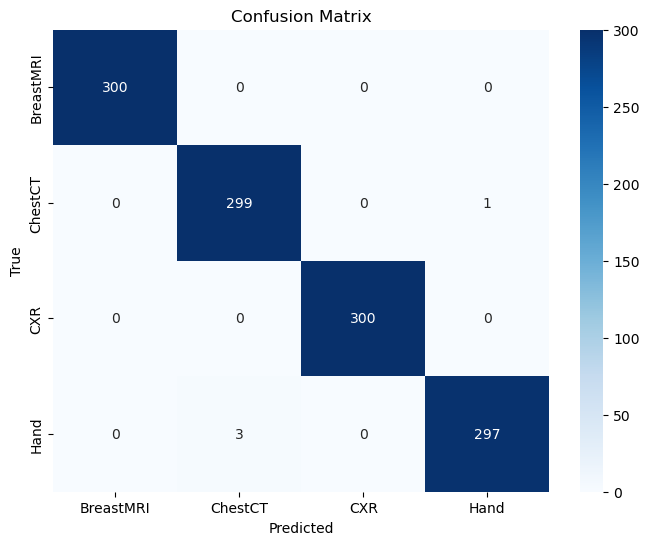


Classification Report:
              precision    recall  f1-score   support

   BreastMRI       1.00      1.00      1.00       300
     ChestCT       0.99      1.00      0.99       300
         CXR       1.00      1.00      1.00       300
        Hand       1.00      0.99      0.99       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



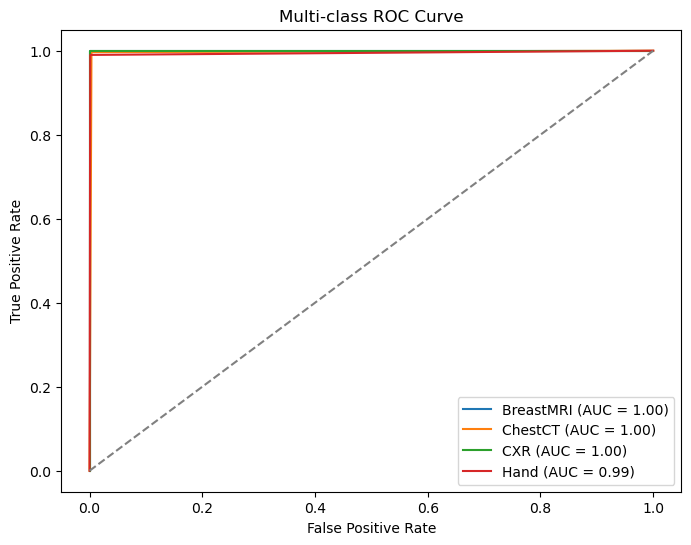

In [168]:
# Ορισμός συσκευής (GPU αν υπάρχει, αλλιώς CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Κωδικοποίηση των κατηγοριών
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Χρήση του αριθμού των κατηγοριών
num_classes = len(label_encoder.classes_)

# Δημιουργία του μοντέλου
model = CNN(num_classes=num_classes, dropout_rate=0.5, activation_fn='ReLU')
model.to(device)  # Μεταφορά του μοντέλου στη συσκευή (GPU ή CPU)

# Ορισμός του Loss Function και του Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Εκπαίδευση του μοντέλου (μόνο με το training set)
def train_model(model, criterion, optimizer, train_loader, num_epochs=20):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Εκπαίδευση του μοντέλου για κάθε μπατς
        for inputs, labels in train_loader:
            # Μεταφορά των δεδομένων (inputs και labels) στη σωστή συσκευή
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Εκτύπωση των αποτελεσμάτων για την εκπαίδευση κάθε εποχής
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    return train_losses, train_accuracies

# Εκτέλεση της εκπαίδευσης
train_losses, train_accuracies = train_model(model, criterion, optimizer, train_loader, num_epochs=20)

# Αξιολόγηση του μοντέλου στο Test Set (μετά την εκπαίδευση)
def evaluate_model_on_test_set(model, test_loader, criterion):
    model.eval()  # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Δεν υπολογίζουμε τα gradients για το test set
        for inputs, labels in test_loader:
            # Μεταφορά των δεδομένων (inputs και labels) στη σωστή συσκευή
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * test_correct / test_total
    test_loss_avg = test_loss / len(test_loader)
    print(f"\nTest Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ROC Curve and AUC for multi-class
    y_test_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))
    outputs_test = torch.tensor(all_preds)  # Predicted labels, as the highest probability class
    fpr, tpr, roc_auc = {}, {}, {}
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], outputs_test == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Εκτέλεση της αξιολόγησης στο Test Set
evaluate_model_on_test_set(model, test_loader, criterion)

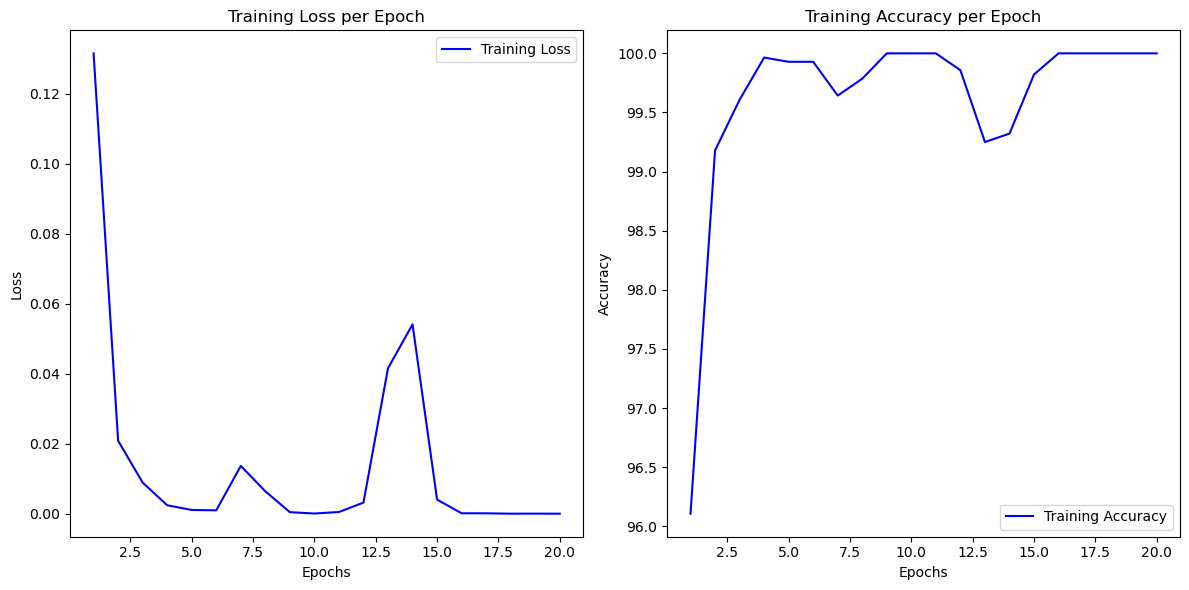

In [169]:
# Οπτικοποίηση της καμπύλης μάθησης (μόνο για το training set)
epochs = range(1, num_epochs + 1)

# Καμπύλη απώλειας
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Καμπύλη ακρίβειας
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Εμφάνιση του διαγράμματος
plt.tight_layout()
plt.show()

Επιπλέον πειραματισμοί 

In [127]:
class CNN_Model(nn.Module):
    def __init__(self, num_layers=3, neurons_per_layer=32, dropout_rate=0.5, use_batchnorm=True, activation_function=nn.ReLU()):
        super(CNN_Model, self).__init__()

        self.num_layers = num_layers
        self.neurons_per_layer = neurons_per_layer
        self.use_batchnorm = use_batchnorm
        self.activation_fn = activation_function
        self.dropout_rate = dropout_rate
        
        # Δημιουργία των Convolutional layers με βάση τον αριθμό των επιπέδων
        layers = []
        in_channels = 1  # Η είσοδος είναι εικόνα 1 καναλιού (ασπρόμαυρη εικόνα)

        for i in range(num_layers):
            out_channels = neurons_per_layer * (2 ** i)  # Αυξάνει το πλήθος των φίλτρων σε κάθε επίπεδο
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))  # Convolutional layer
            if self.use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))  # Batch Normalization layer
            layers.append(self.activation_fn)  # Συνάρτηση ενεργοποίησης
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling layer
            in_channels = out_channels  # Ενημέρωση του αριθμού των καναλιών εισόδου για το επόμενο layer

        self.conv_layers = nn.Sequential(*layers)

        # Υπολογισμός του μεγέθους εισόδου για το Fully Connected layer
        self.fc_input_size = self._get_fc_input_size(torch.randn(1, 1, 64, 64))

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc_input_size, 512)  # Πρώτο πλήρως συνδεδεμένο επίπεδο
        self.dropout = nn.Dropout(dropout_rate)  # Dropout για regularization
        self.fc2 = nn.Linear(512, 10)  # Τελική έξοδος (10 κατηγορίες)

    def _get_fc_input_size(self, x):
        x = self.conv_layers(x)  # Πέρασμα από τα Convolutional layers
        return x.view(x.size(0), -1).size(1)  # Επιστρέφει το μέγεθος του flattened tensor

    def forward(self, x):
        # Πέρασμα από τα Convolutional layers
        x = self.conv_layers(x)
        
        # Flattening πριν το Fully Connected
        x = torch.flatten(x, 1)

        # Πλήρως συνδεδεμένα επίπεδα
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [128]:
# Μεταφορά των Tensors στο CPU και μετατροπή τους σε numpy arrays
X_train_cpu = X_train_tensor.cpu().numpy()
y_train_cpu = y_train_tensor.cpu().numpy()

# Ορισμός του device για GPU ή CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Διαχωρισμός των παραμέτρων για testing (μόνο οι πρώτες παραμέτρους)
param_grid = {
    'learning_rate': [0.001, 0.01],  # Μικρότερη γκάμα ρυθμών μάθησης
    'dropout_rate': [0.3, 0.5],       # Μικρότερη γκάμα dropout
    'num_layers': [2, 3],             # Δοκιμάζουμε 2 και 3 επίπεδα
    'neurons_per_layer': [64, 128],   # Δοκιμάζουμε 64 και 128 νευρώνες ανά επίπεδο
    'activation_function': [nn.ReLU(), nn.Sigmoid()],  # Δοκιμάζουμε ReLU και Sigmoid
    'weight_decay': [0]               # Χωρίς regularization για γρηγορότερη εκτέλεση
}

# Διαχωρισμός του train set σε train και validation μέσω StratifiedKFold
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Δημιουργία και ορισμός του μοντέλου, της συνάρτησης απώλειας και του βελτιστοποιητή
best_params = None
best_val_accuracy = 0
best_model = None  # Αποθήκευση του καλύτερου μοντέλου
history = {
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}

# Εκτέλεση της cross-validation διαδικασίας
for learning_rate in param_grid['learning_rate']:
    for dropout_rate in param_grid['dropout_rate']:
        for num_layers in param_grid['num_layers']:
            for neurons_per_layer in param_grid['neurons_per_layer']:
                for activation_function in param_grid['activation_function']:
                    
                    print(f"Testing with learning_rate={learning_rate}, dropout_rate={dropout_rate}, "
                          f"num_layers={num_layers}, neurons_per_layer={neurons_per_layer}, "
                          f"activation_function={activation_function.__class__.__name__}")
                    
                    fold_accuracies = []
                    fold_losses = []

                    # Cross-validation loop
                    for fold, (train_idx, val_idx) in enumerate(stratified_kf.split(X_train_cpu, y_train_cpu)):
                        print(f"Training fold {fold+1}/{stratified_kf.get_n_splits()}")

                        # Δημιουργία του train και validation dataset για αυτό το fold
                        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
                        val_subset = torch.utils.data.Subset(train_dataset, val_idx)

                        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
                        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
                        
                        # Δημιουργία του μοντέλου με τις τρέχουσες παραμέτρους
                        model = CNN_Model(num_layers=num_layers, 
                                          neurons_per_layer=neurons_per_layer, 
                                          dropout_rate=dropout_rate, 
                                          activation_function=activation_function).to(device)
                        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                        criterion = nn.CrossEntropyLoss()

                        # Εκπαίδευση για 10 εποχές
                        for epoch in range(10): 
                            model.train()
                            running_loss = 0.0
                            correct = 0
                            total = 0
                            for inputs, labels in train_loader:
                                # Μεταφορά των δεδομένων στο device (GPU ή CPU)
                                inputs, labels = inputs.to(device), labels.to(device)
                                optimizer.zero_grad()

                                outputs = model(inputs)
                                loss = criterion(outputs, labels)
                                loss.backward()
                                optimizer.step()

                                running_loss += loss.item()
                                _, predicted = torch.max(outputs, 1)
                                total += labels.size(0)
                                correct += (predicted == labels).sum().item()

                            train_accuracy = 100 * correct / total
                            history['train_losses'].append(running_loss / len(train_loader))
                            history['train_accuracies'].append(train_accuracy)

                            # Validation Evaluation
                            model.eval()
                            val_loss = 0.0
                            val_correct = 0
                            val_total = 0
                            with torch.no_grad():
                                for inputs, labels in val_loader:
                                    # Μεταφορά των δεδομένων στο device (GPU ή CPU)
                                    inputs, labels = inputs.to(device), labels.to(device)

                                    outputs = model(inputs)
                                    loss = criterion(outputs, labels)

                                    val_loss += loss.item()
                                    _, predicted = torch.max(outputs, 1)
                                    val_total += labels.size(0)
                                    val_correct += (predicted == labels).sum().item()

                            val_accuracy = 100 * val_correct / val_total
                            fold_accuracies.append(val_accuracy)
                            fold_losses.append(val_loss / len(val_loader))

                    # Υπολογισμός μέσης ακρίβειας και απώλειας για κάθε συνδυασμό παραμέτρων
                    mean_val_accuracy = np.mean(fold_accuracies)
                    print(f"Mean validation accuracy: {mean_val_accuracy:.2f}%")
                    
                    # Αποθήκευση του καλύτερου συνδυασμού παραμέτρων και μοντέλου
                    if mean_val_accuracy > best_val_accuracy:
                        best_val_accuracy = mean_val_accuracy
                        best_params = {
                            'learning_rate': learning_rate, 
                            'dropout_rate': dropout_rate,
                            'num_layers': num_layers,
                            'neurons_per_layer': neurons_per_layer,
                            'activation_function': activation_function.__class__.__name__
                        }
                        best_model = model  # Αποθήκευση του καλύτερου μοντέλου

# Εκτύπωση των βέλτιστων παραμέτρων
print(f"Best Parameters: {best_params}")

# Αποθήκευση του καλύτερου μοντέλου
torch.save(best_model.state_dict(), 'best_model.pth')


Using device: cuda
Testing with learning_rate=0.001, dropout_rate=0.3, num_layers=2, neurons_per_layer=64, activation_function=ReLU
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Mean validation accuracy: 99.53%
Testing with learning_rate=0.001, dropout_rate=0.3, num_layers=2, neurons_per_layer=64, activation_function=Sigmoid
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Mean validation accuracy: 97.96%
Testing with learning_rate=0.001, dropout_rate=0.3, num_layers=2, neurons_per_layer=128, activation_function=ReLU
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Mean validation accuracy: 99.30%
Testing with learning_rate=0.001, dropout_rate=0.3, num_layers=2, neurons_per_layer=128, activation_function=Sigmoid
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Mean validation accuracy: 88.24%
Testing with learning_rate=0.

In [129]:
# Ανάκτηση των καλύτερων παραμέτρων από τα αποτελέσματα της cross-validation
num_layers = best_params['num_layers']
neurons_per_layer = best_params['neurons_per_layer']
dropout_rate = best_params['dropout_rate']
activation_function = nn.ReLU() if best_params['activation_function'] == 'ReLU' else nn.Sigmoid()
learning_rate = best_params['learning_rate']

# Ορισμός του μοντέλου με τις καλύτερες παραμέτρους
best_model = CNN_Model(
    num_layers=num_layers,
    neurons_per_layer=neurons_per_layer,
    dropout_rate=dropout_rate,
    activation_function=activation_function,
    use_batchnorm=True  # Αν χρησιμοποιείς batch normalization
).to(device)

# Ορισμός του βελτιστοποιητή και της συνάρτησης απώλειας
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Εκπαίδευση του μοντέλου στο πλήρες train set (20 εποχές)
for epoch in range(20):  # 20 εποχές
    best_model.train()  # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:  # Χρησιμοποιούμε τον DataLoader για το train set
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Μηδενίζουμε τα gradients

        outputs = best_model(inputs)  # Υπολογισμός εξόδου του μοντέλου
        loss = criterion(outputs, labels)  # Υπολογισμός απώλειας
        loss.backward()  # Υπολογισμός των gradients
        optimizer.step()  # Ενημέρωση των παραμέτρων του μοντέλου

        running_loss += loss.item()  # Προσθήκη της απώλειας στην τρέχουσα απώλεια
        _, predicted = torch.max(outputs, 1)  # Επιλογή της κλάσης με την υψηλότερη πιθανότητα
        total += labels.size(0)  # Αριθμός παραδειγμάτων
        correct += (predicted == labels).sum().item()  # Αριθμός σωστών προβλέψεων

    # Εκτύπωση του μέσου όρου της απώλειας και ακρίβειας για αυτήν την εποχή
    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/20], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

Epoch [1/20], Loss: 0.6895, Accuracy: 95.13%
Epoch [2/20], Loss: 0.2067, Accuracy: 98.97%
Epoch [3/20], Loss: 0.0979, Accuracy: 99.38%
Epoch [4/20], Loss: 0.1372, Accuracy: 99.24%
Epoch [5/20], Loss: 0.0317, Accuracy: 99.82%
Epoch [6/20], Loss: 0.0639, Accuracy: 99.69%
Epoch [7/20], Loss: 0.0318, Accuracy: 99.82%
Epoch [8/20], Loss: 0.0130, Accuracy: 99.87%
Epoch [9/20], Loss: 0.1149, Accuracy: 99.46%
Epoch [10/20], Loss: 0.0078, Accuracy: 99.96%
Epoch [11/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [12/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [13/20], Loss: 0.0033, Accuracy: 99.91%
Epoch [14/20], Loss: 0.0555, Accuracy: 99.64%
Epoch [15/20], Loss: 0.0371, Accuracy: 99.78%
Epoch [16/20], Loss: 0.0140, Accuracy: 99.91%
Epoch [17/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0169, Accuracy: 99.82%
Epoch [19/20], Loss: 0.0593, Accuracy: 99.73%
Epoch [20/20], Loss: 0.0205, Accuracy: 99.87%


Accuracy of the model on the test set: 99.83%


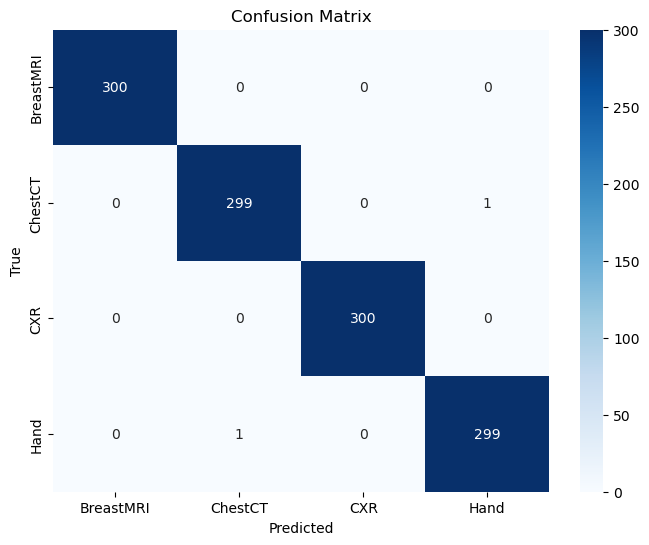


Classification Report:
              precision    recall  f1-score   support

   BreastMRI       1.00      1.00      1.00       300
     ChestCT       1.00      1.00      1.00       300
         CXR       1.00      1.00      1.00       300
        Hand       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



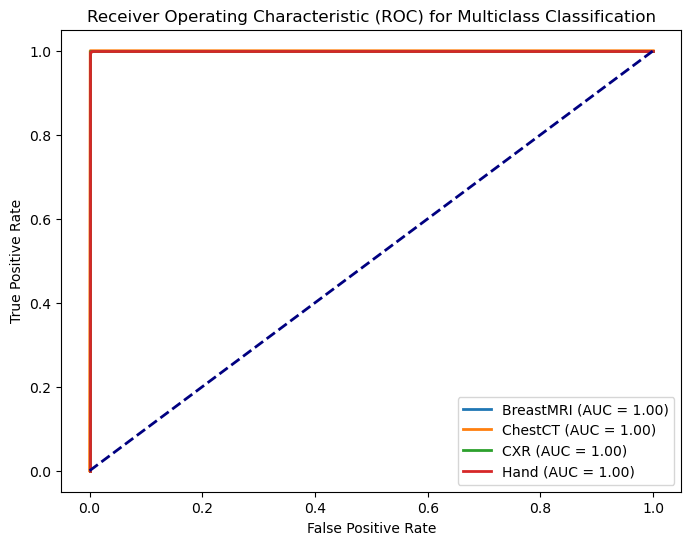

In [130]:
# Αξιολόγηση του μοντέλου στο test set μετά την εκπαίδευση
best_model.eval()  # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης (χωρίς ενημέρωση των weights)
correct = 0
total = 0
all_preds = []
all_labels = []
all_outputs = []

with torch.no_grad():  # Απενεργοποιούμε τον υπολογισμό των gradients
    for inputs, labels in test_loader:  # Χρησιμοποιούμε τον DataLoader για το test set
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model(inputs)  # Υπολογισμός εξόδου του μοντέλου
        _, predicted = torch.max(outputs, 1)  # Επιλογή της κλάσης με την υψηλότερη πιθανότητα
        
        total += labels.size(0)  # Αριθμός παραδειγμάτων
        correct += (predicted == labels).sum().item()  # Αριθμός σωστών προβλέψεων

        all_preds.extend(predicted.cpu().numpy())  # Συσσωρεύουμε τις προβλέψεις
        all_labels.extend(labels.cpu().numpy())  # Συσσωρεύουμε τις πραγματικές ετικέτες
        all_outputs.extend(outputs.cpu().numpy())  # Συσσωρεύουμε τις εξόδους του μοντέλου (logits)

# Υπολογισμός της ακρίβειας στο test set
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Εξασφαλίζουμε ότι οι ετικέτες (labels) είναι δυαδικές για κάθε κατηγορία (One-vs-Rest)
all_labels_bin = label_binarize(all_labels, classes=[i for i in range(len(class_names))])

# Δημιουργία του numpy array πρώτα και μετά τη μετατροπή σε tensor
outputs_prob = torch.nn.functional.softmax(torch.tensor(np.array(all_outputs)), dim=1).numpy()

# Υπολογισμός ROC Curve και AUC για κάθε κατηγορία
fpr = {}
tpr = {}
roc_auc = {}

# Υπολογίζουμε ROC για κάθε κατηγορία
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], outputs_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Σχεδιάζουμε τις ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Εμφάνιση της διαγώνιας γραμμής (τυχαία πρόβλεψη)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Σήμανση του διαγράμματος
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()